# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## Settings

In [1]:
# CONTROLS
MODEL_PREFIX = "V10"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.3
MIN_LR = 1e-6
MAX_LR = 1e-3
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 10
CLR_METHOD = "triangular2" # exp_range, triangular, triangular2
NUM_EPOCHS = 1000

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import pickle, os, sys, re

import spacy
from spacy.lang.en import English

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [3]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import Data

In [5]:
df = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16},
                 encoding="utf8")

df2 = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16})

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID                                                   text  \
count   27481       27480                                                   
unique  27481       27480                                                   
top     233197e487   ok... maybe not angry... just with very little sense   
freq    1           1                                                       

       selected_text sentiment  
count   27480         27481     
unique  22463         3         
top     good          neutral   
freq    199           11118     


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [6]:
test_df = pd.read_csv("../data/test.csv", dtype={"time":np.float64,"signal":np.float64})
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID  \
count   3534         
unique  3534         
top     f7835156a5   
freq    1            

                                                                                                                                            text  \
count   3534                                                                                                                                       
unique  3534                                                                                                                                       
top     spirit week! Tuesday have to be in make up by eight so I can die later. School wednesday and thursday then, finally sleep in on Friday!!   
freq    1                                                                                                                                          

       

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [7]:
df.loc[df2['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [8]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Exploration

#### Sentiment count in training

In [9]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [10]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [11]:
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 5)
(27480, 5)


In [12]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [13]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

#### Tagging

In [14]:
def preprocess_text(x, extra_string=None):
    x = x.lower()
    x = re.sub('([!"#$%&()*+,-./:;\'<=>?@[\\]^_{|}~\t\n])', ' \\1 ', x) # Not including ` here since used in couldn`t, isn`t
    x = x.strip()
    x = re.sub(' +', ' ', x)
    x = x.split(" ")
    if extra_string is not None:
        x = ["xxxSTART"] + x + ["xxxSENTIMENT"] + [extra_string] + ["xxxEND"]
    return x

In [15]:
def get_extremities(l_string, s_string, extra_string, print_it=False):
    l_string = preprocess_text(l_string, extra_string)
    s_string = preprocess_text(s_string, extra_string=None)
    
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = np.zeros(len_l, dtype=np.int16), np.zeros(len_l, dtype=np.int16)
                att_vector = np.ones(len_l, dtype=np.int16)
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (l_string, s_string, start_vector, end_vector, att_vector)

In [16]:
idx = 100
get_extremities(df.text[idx], df.selected_text[idx], df.sentiment[idx], print_it=False)

(['xxxSTART',
  '4am',
  '.',
  'and',
  'im',
  'on',
  'the',
  'beach',
  '.',
  'pretty',
  'xxxSENTIMENT',
  'positive',
  'xxxEND'],
 ['pretty'],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16))

In [17]:
df[["text_mod", "selected_text_mod", "target_start", "target_stop", "target_atten"]] = df.apply(lambda x: get_extremities(x.text, x.selected_text, x.sentiment), axis=1).apply(pd.Series)
test_df[["text_mod"]] = test_df.apply(lambda x: [preprocess_text(x.text, extra_string = x.sentiment)], axis=1).apply(pd.Series)

In [18]:
df.isna().sum()

textID               0   
text                 0   
selected_text        0   
sentiment            0   
original_index       0   
sentiment_code       0   
text_mod             1476
selected_text_mod    1476
target_start         1476
target_stop          1476
target_atten         1476
dtype: int64

In [19]:
test_df.isna().sum()

textID            0
text              0
sentiment         0
original_index    0
sentiment_code    0
text_mod          0
dtype: int64

In [20]:
df.head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0,neutral,"[xxxSTART, i`d, have, responded, ,, if, i, were, going, xxxSENTIMENT, neutral, xxxEND]","[i`d, have, responded, ,, if, i, were, going]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1,negative,"[xxxSTART, sooo, sad, i, will, miss, you, here, in, san, diego, !, !, !, xxxSENTIMENT, negative, xxxEND]","[sooo, sad]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [21]:
df.iloc[df.loc[df['target_start'].isna()].index].head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,18,negative,NaN,NaN,NaN,NaN,NaN
32,1c31703aef,If it is any consolation I got my BMI tested hahaha it says I am obesed well so much for being unhappy for about 10 minutes.,well so much for being unhappy for about 10 minute,negative,32,negative,NaN,NaN,NaN,NaN,NaN


In [22]:
test_df.head(2)

,textID,text,sentiment,original_index,sentiment_code,text_mod
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0,neutral,"[xxxSTART, last, session, of, the, day, http, :, /, /, twitpic, ., com, /, 67ezh, xxxSENTIMENT, neutral, xxxEND]"
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,1,positive,"[xxxSTART, shanghai, is, also, really, exciting, (, precisely, -, -, skyscrapers, galore, ), ., good, tweeps, in, china, :, (, sh, ), (, bj, ), ., xxxSENTIMENT, positive, xxxEND]"


In [23]:
anomalous_idxs = df.loc[df['target_start'].isna()].index.tolist()

In [24]:
print(df.shape)
df = df[~df.index.isin(anomalous_idxs)]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27480, 11)
(26004, 11)


#### Tokenization

In [25]:
X_words = df['text_mod'].apply(lambda x:list(x)).tolist()
X_att = df['target_atten'].apply(lambda x:list(x)).tolist()

X_words_test = test_df['text_mod'].apply(lambda x:list(x)).tolist()
X_att_test = [[1 for j in i] for i in X_words_test]

Y_words = df['selected_text_mod'].apply(lambda x:list(x)).tolist()
Y_starts = df['target_start'].apply(lambda x:list(x)).tolist()
Y_stops = df['target_stop'].apply(lambda x:list(x)).tolist()

print("\n",
    "X_words:","\t", len(X_words),"\n",
    "X_att:","\t", len(X_att),"\n",
    "Y_words:","\t", len(Y_words),"\n",
    "Y_starts:","\t", len(Y_starts),"\n",
    "Y_stops:","\t", len(Y_stops),"\n",
    "X_words_test:","\t", len(X_words_test),"\n",
    "X_att_test:","\t", len(X_att_test),"\n"
)


 X_words: 	 26004 
 X_att: 	 26004 
 Y_words: 	 26004 
 Y_starts: 	 26004 
 Y_stops: 	 26004 
 X_words_test: 	 3534 
 X_att_test: 	 3534 



In [26]:
print(sum([len(i)==len(j) for i,j in zip(X_att_test, X_words_test)]))
print(sum([len(i)==len(j) for i,j in zip(X_att, X_words)]))

3534
26004


In [27]:
from collections import Counter
word_counts = Counter([j for i in X_words for j in i])

X_unique_tokens = len(word_counts)
word_counts.most_common(10)

[('.', 33619),
 ('xxxSTART', 26004),
 ('xxxSENTIMENT', 26004),
 ('xxxEND', 26004),
 ('!', 14379),
 ('i', 12615),
 ('neutral', 10941),
 ('to', 9447),
 ('the', 8445),
 (',', 7984)]

In [28]:
MIN_WORD_FREQ = 2

In [29]:
word_subset = [i for i,j in word_counts.items() if j >= MIN_WORD_FREQ]
print("VOCAB reduced from", len(word_counts), "to", len(word_subset))

VOCAB reduced from 25847 to 10178


In [30]:
#list_of_words = set(sorted([j for i in X_words for j in i]))
#Y_list_of_words = set(sorted([j for i in Y_words for j in i]))

In [31]:
vocab_itos = {i+2:j for i,j in enumerate(word_subset)}
vocab_stoi = {j:i+2 for i,j in enumerate(word_subset)}

vocab_stoi["xxxUNK"] = 1
vocab_itos[1] = "xxxUNK"

vocab_stoi["xxxNone"] = 0
vocab_itos[0] = "xxxNone"

In [32]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = vocab_stoi["xxxUNK"]
    return value

In [33]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words_test]

In [34]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = len(vocab_stoi)
print(VOCAB_SIZE, max_len)

10180 110


#### Train Validation  split

In [35]:
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO * len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

26004 20803 5201 26004


In [36]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 20803 	 : X_train 
 20803 	 : X_att_train 
 20803 	 : Y_train 
 20803 	 : Y_starts_train 
 20803 	 : Y_stops_train 
 5201 	 : X_val 
 5201 	 : X_att_val 
 5201 	 : Y_val 
 5201 	 : Y_starts_val 
 5201 	 : Y_stops_val 



#### Padding

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [38]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [39]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (20803, 110) 	: X_train  
 (20803, 110) 	: X_att_train  
 (20803, 110) 	: Y_train  
 (20803, 110) 	: Y_starts_train  
 (20803, 110) 	: Y_stops_train  
 (5201, 110) 	: X_val  
 (5201, 110) 	: X_att_val  
 (5201, 110) 	: Y_val  
 (5201, 110) 	: Y_starts_val  
 (5201, 110) 	: Y_stops_val  
 (3534, 110) 	: X_test  
 (3534, 110) 	: X_att_test  



#### Checking for zero input vectors

In [40]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 36
0 36


#### Check inputs and outputs

In [41]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[2, 1, 1662, 0, 0],
 [87, 1, 648, 0, 0],
 [17, 1, 2533, 0, 0],
 [2174, 1, 7, 0, 0],
 [669, 1, 1685, 0, 0],
 [84, 1, 278, 0, 0],
 [1662, 1, 17, 1, 0],
 [648, 1, 229, 0, 0],
 [2533, 1, 4625, 0, 0],
 [7, 1, 116, 0, 0],
 [1685, 1, 44, 0, 0],
 [278, 1, 406, 0, 0],
 [17, 1, 8227, 0, 0],
 [229, 1, 0, 0, 0],
 [4625, 1, 0, 0, 0],
 [116, 1, 0, 0, 0],
 [44, 1, 0, 0, 0],
 [406, 1, 0, 0, 0],
 [8227, 1, 0, 0, 1],
 [7492, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 

In [42]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[2, 1, 9890, 0, 0],
 [9890, 1, 8753, 1, 0],
 [8753, 1, 55, 0, 0],
 [55, 1, 4465, 0, 0],
 [4465, 1, 305, 0, 0],
 [305, 1, 1, 0, 0],
 [1, 1, 28, 0, 0],
 [28, 1, 0, 0, 1],
 [47, 1, 0, 0, 0],
 [48, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [50, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [51, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [9890, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [7327, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],


In [43]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_words_test[num],
                          X_test[num],
                          X_att_test[num])]

[['xxxSTART', 2, 1],
 ['oooh', 3482, 1],
 [',', 5, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['a', 142, 1],
 ['patch', 905, 1],
 ['of', 34, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['and', 68, 1],
 ['it', 144, 1],
 ['will', 15, 1],
 ['be', 89, 1],
 ['gone', 544, 1],
 ['by', 106, 1],
 ['the', 42, 1],
 ['time', 504, 1],
 ['i', 7, 1],
 ['leave', 31, 1],
 ['work', 342, 1],
 ['and', 68, 1],
 ['replaced', 1, 1],
 ['with', 278, 1],
 ['rain', 1901, 1],
 ['.', 28, 1],
 ['/', 49, 1],
 ['vent', 9146, 1],
 ['xxxSENTIMENT', 10, 1],
 ['neutral', 11, 1],
 ['xxxEND', 12, 1]]

## Model

In [44]:
input_att_flags = Input((max_len), name="att_flags")
input_sequences = Input((max_len), name="words")

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(16, activation=None, return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(16, activation=None, return_sequences=False))(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Dense(max_len, activation="relu")(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

att = Dense(max_len, activation="relu")(input_att_flags)
att = BatchNormalization()(att)
att = Dropout(DROPOUT)(att)

convs = Conv1D(filters=32, kernel_size=8, padding="causal", activation=None)(emb_sequences)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="causal", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

convs = Flatten()(convs)
convs = Dense(max_len, activation='relu')(convs)

seq = Multiply()([convs, seq])
seq = Multiply()([att, seq])

output_starts = Dense(max_len, activation='softmax', name="starts")(seq)
output_stops = Dense(max_len, activation='softmax', name="stops")(seq)

In [45]:
model = Model([input_att_flags, input_sequences], [output_starts, output_stops])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 110)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 110, 64)      651520      words[0][0]                      
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 110, 32)      10368       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 110, 32)      16416       embedding[0][0]                  
______________________________________________________________________________________________

In [46]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam , metrics=['accuracy'])

In [47]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [48]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

Train on 20803 samples, validate on 5201 samples
Epoch 1/1000
20803/20803 [==============================] - 23s 1ms/sample - loss: 9.9363 - starts_loss: 4.9446 - stops_loss: 4.9783 - starts_accuracy: 0.0136 - stops_accuracy: 0.0086 - val_loss: 9.3978 - val_starts_loss: 4.6988 - val_stops_loss: 4.6990 - val_starts_accuracy: 0.0925 - val_stops_accuracy: 0.0506
Epoch 2/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 9.4409 - starts_loss: 4.7132 - stops_loss: 4.7254 - starts_accuracy: 0.0314 - stops_accuracy: 0.0164 - val_loss: 9.3887 - val_starts_loss: 4.6941 - val_stops_loss: 4.6946 - val_starts_accuracy: 0.0410 - val_stops_accuracy: 0.0931
Epoch 3/1000
20803/20803 [==============================] - 13s 611us/sample - loss: 9.3605 - starts_loss: 4.6701 - stops_loss: 4.6893 - starts_accuracy: 0.1129 - stops_accuracy: 0.0329 - val_loss: 9.3752 - val_starts_loss: 4.6877 - val_stops_loss: 4.6877 - val_starts_accuracy: 0.0521 - val_stops_accuracy: 0.0863
Epoch 4/

Epoch 27/1000
20803/20803 [==============================] - 13s 603us/sample - loss: 3.1437 - starts_loss: 1.5167 - stops_loss: 1.6318 - starts_accuracy: 0.5973 - stops_accuracy: 0.5754 - val_loss: 4.0053 - val_starts_loss: 1.9217 - val_stops_loss: 2.1232 - val_starts_accuracy: 0.5970 - val_stops_accuracy: 0.5062
Epoch 28/1000
20803/20803 [==============================] - 13s 610us/sample - loss: 3.1065 - starts_loss: 1.5000 - stops_loss: 1.6091 - starts_accuracy: 0.5973 - stops_accuracy: 0.5742 - val_loss: 3.8365 - val_starts_loss: 1.8586 - val_stops_loss: 2.0153 - val_starts_accuracy: 0.5953 - val_stops_accuracy: 0.5189
Epoch 29/1000
20803/20803 [==============================] - 13s 603us/sample - loss: 3.0565 - starts_loss: 1.4800 - stops_loss: 1.5799 - starts_accuracy: 0.5982 - stops_accuracy: 0.5817 - val_loss: 3.7033 - val_starts_loss: 1.8060 - val_stops_loss: 1.9324 - val_starts_accuracy: 0.5974 - val_stops_accuracy: 0.5401
Epoch 30/1000
20803/20803 [=========================

Epoch 53/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.4455 - starts_loss: 1.2077 - stops_loss: 1.2360 - starts_accuracy: 0.6265 - stops_accuracy: 0.6458 - val_loss: 2.8970 - val_starts_loss: 1.4783 - val_stops_loss: 1.4453 - val_starts_accuracy: 0.6055 - val_stops_accuracy: 0.6135
Epoch 54/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.4245 - starts_loss: 1.1984 - stops_loss: 1.2219 - starts_accuracy: 0.6305 - stops_accuracy: 0.6471 - val_loss: 2.9064 - val_starts_loss: 1.4861 - val_stops_loss: 1.4469 - val_starts_accuracy: 0.6045 - val_stops_accuracy: 0.6151
Epoch 55/1000
20803/20803 [==============================] - 12s 592us/sample - loss: 2.4037 - starts_loss: 1.1919 - stops_loss: 1.2119 - starts_accuracy: 0.6324 - stops_accuracy: 0.6436 - val_loss: 2.9057 - val_starts_loss: 1.4825 - val_stops_loss: 1.4494 - val_starts_accuracy: 0.6072 - val_stops_accuracy: 0.6153
Epoch 56/1000
20803/20803 [=========================

Epoch 79/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.2129 - starts_loss: 1.1179 - stops_loss: 1.1049 - starts_accuracy: 0.6503 - stops_accuracy: 0.6694 - val_loss: 2.9451 - val_starts_loss: 1.4914 - val_stops_loss: 1.4809 - val_starts_accuracy: 0.6107 - val_stops_accuracy: 0.6220
Epoch 80/1000
20803/20803 [==============================] - 13s 606us/sample - loss: 2.2158 - starts_loss: 1.1081 - stops_loss: 1.0995 - starts_accuracy: 0.6495 - stops_accuracy: 0.6760 - val_loss: 2.9424 - val_starts_loss: 1.4903 - val_stops_loss: 1.4800 - val_starts_accuracy: 0.6107 - val_stops_accuracy: 0.6231
Epoch 81/1000
20803/20803 [==============================] - 12s 594us/sample - loss: 2.2182 - starts_loss: 1.1033 - stops_loss: 1.1127 - starts_accuracy: 0.6508 - stops_accuracy: 0.6729 - val_loss: 2.9434 - val_starts_loss: 1.4901 - val_stops_loss: 1.4810 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.6216
Epoch 82/1000
20803/20803 [=========================

Epoch 105/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.1484 - starts_loss: 1.0735 - stops_loss: 1.0749 - starts_accuracy: 0.6567 - stops_accuracy: 0.6830 - val_loss: 2.9693 - val_starts_loss: 1.5058 - val_stops_loss: 1.4957 - val_starts_accuracy: 0.6137 - val_stops_accuracy: 0.6245
Epoch 106/1000
20803/20803 [==============================] - 13s 604us/sample - loss: 2.1196 - starts_loss: 1.0563 - stops_loss: 1.0581 - starts_accuracy: 0.6632 - stops_accuracy: 0.6846 - val_loss: 2.9818 - val_starts_loss: 1.5028 - val_stops_loss: 1.5095 - val_starts_accuracy: 0.6118 - val_stops_accuracy: 0.6220
Epoch 107/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.1252 - starts_loss: 1.0741 - stops_loss: 1.0497 - starts_accuracy: 0.6578 - stops_accuracy: 0.6860 - val_loss: 2.9705 - val_starts_loss: 1.5053 - val_stops_loss: 1.4965 - val_starts_accuracy: 0.6126 - val_stops_accuracy: 0.6251
Epoch 108/1000
20803/20803 [=====================

Epoch 131/1000
20803/20803 [==============================] - 12s 595us/sample - loss: 2.0831 - starts_loss: 1.0555 - stops_loss: 1.0275 - starts_accuracy: 0.6628 - stops_accuracy: 0.6930 - val_loss: 2.9882 - val_starts_loss: 1.5123 - val_stops_loss: 1.5090 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6243
Epoch 132/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 2.0889 - starts_loss: 1.0553 - stops_loss: 1.0359 - starts_accuracy: 0.6662 - stops_accuracy: 0.6924 - val_loss: 2.9872 - val_starts_loss: 1.5126 - val_stops_loss: 1.5078 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6245
Epoch 133/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0875 - starts_loss: 1.0429 - stops_loss: 1.0387 - starts_accuracy: 0.6657 - stops_accuracy: 0.6924 - val_loss: 2.9903 - val_starts_loss: 1.5123 - val_stops_loss: 1.5109 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6239
Epoch 134/1000
20803/20803 [=====================

Epoch 157/1000
20803/20803 [==============================] - 12s 595us/sample - loss: 2.0844 - starts_loss: 1.0504 - stops_loss: 1.0308 - starts_accuracy: 0.6651 - stops_accuracy: 0.6934 - val_loss: 2.9948 - val_starts_loss: 1.5154 - val_stops_loss: 1.5129 - val_starts_accuracy: 0.6147 - val_stops_accuracy: 0.6237
Epoch 158/1000
20803/20803 [==============================] - 13s 615us/sample - loss: 2.0753 - starts_loss: 1.0481 - stops_loss: 1.0256 - starts_accuracy: 0.6652 - stops_accuracy: 0.6952 - val_loss: 2.9971 - val_starts_loss: 1.5146 - val_stops_loss: 1.5156 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6239
Epoch 159/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.0780 - starts_loss: 1.0467 - stops_loss: 1.0300 - starts_accuracy: 0.6629 - stops_accuracy: 0.6931 - val_loss: 2.9969 - val_starts_loss: 1.5144 - val_stops_loss: 1.5157 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6243
Epoch 160/1000
20803/20803 [=====================

Epoch 183/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.0781 - starts_loss: 1.0523 - stops_loss: 1.0264 - starts_accuracy: 0.6668 - stops_accuracy: 0.6918 - val_loss: 3.0062 - val_starts_loss: 1.5175 - val_stops_loss: 1.5213 - val_starts_accuracy: 0.6128 - val_stops_accuracy: 0.6247
Epoch 184/1000
20803/20803 [==============================] - 13s 615us/sample - loss: 2.0684 - starts_loss: 1.0430 - stops_loss: 1.0263 - starts_accuracy: 0.6663 - stops_accuracy: 0.6948 - val_loss: 3.0027 - val_starts_loss: 1.5171 - val_stops_loss: 1.5186 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6239
Epoch 185/1000
20803/20803 [==============================] - 13s 603us/sample - loss: 2.0784 - starts_loss: 1.0427 - stops_loss: 1.0280 - starts_accuracy: 0.6645 - stops_accuracy: 0.6934 - val_loss: 3.0005 - val_starts_loss: 1.5169 - val_stops_loss: 1.5167 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6243
Epoch 186/1000
20803/20803 [=====================

Epoch 209/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.0549 - starts_loss: 1.0339 - stops_loss: 1.0212 - starts_accuracy: 0.6676 - stops_accuracy: 0.6960 - val_loss: 3.0054 - val_starts_loss: 1.5176 - val_stops_loss: 1.5209 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6247
Epoch 210/1000
20803/20803 [==============================] - 13s 611us/sample - loss: 2.0502 - starts_loss: 1.0368 - stops_loss: 1.0116 - starts_accuracy: 0.6658 - stops_accuracy: 0.6966 - val_loss: 3.0053 - val_starts_loss: 1.5179 - val_stops_loss: 1.5207 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6247
Epoch 211/1000
20803/20803 [==============================] - 13s 608us/sample - loss: 2.0686 - starts_loss: 1.0422 - stops_loss: 1.0275 - starts_accuracy: 0.6687 - stops_accuracy: 0.6944 - val_loss: 3.0055 - val_starts_loss: 1.5181 - val_stops_loss: 1.5207 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6251
Epoch 212/1000
20803/20803 [=====================

Epoch 235/1000
20803/20803 [==============================] - 12s 591us/sample - loss: 2.0580 - starts_loss: 1.0406 - stops_loss: 1.0162 - starts_accuracy: 0.6678 - stops_accuracy: 0.6936 - val_loss: 3.0058 - val_starts_loss: 1.5187 - val_stops_loss: 1.5206 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6245
Epoch 236/1000
20803/20803 [==============================] - 13s 601us/sample - loss: 2.0790 - starts_loss: 1.0489 - stops_loss: 1.0283 - starts_accuracy: 0.6638 - stops_accuracy: 0.6928 - val_loss: 3.0051 - val_starts_loss: 1.5188 - val_stops_loss: 1.5199 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6241
Epoch 237/1000
20803/20803 [==============================] - 13s 608us/sample - loss: 2.0660 - starts_loss: 1.0496 - stops_loss: 1.0151 - starts_accuracy: 0.6636 - stops_accuracy: 0.6977 - val_loss: 3.0048 - val_starts_loss: 1.5185 - val_stops_loss: 1.5199 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6241
Epoch 238/1000
20803/20803 [=====================

Epoch 261/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 2.0561 - starts_loss: 1.0395 - stops_loss: 1.0213 - starts_accuracy: 0.6693 - stops_accuracy: 0.6950 - val_loss: 3.0093 - val_starts_loss: 1.5202 - val_stops_loss: 1.5227 - val_starts_accuracy: 0.6130 - val_stops_accuracy: 0.6253
Epoch 262/1000
20803/20803 [==============================] - 12s 592us/sample - loss: 2.0566 - starts_loss: 1.0408 - stops_loss: 1.0156 - starts_accuracy: 0.6684 - stops_accuracy: 0.6968 - val_loss: 3.0091 - val_starts_loss: 1.5205 - val_stops_loss: 1.5223 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6251
Epoch 263/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 2.0559 - starts_loss: 1.0398 - stops_loss: 1.0168 - starts_accuracy: 0.6692 - stops_accuracy: 0.6961 - val_loss: 3.0070 - val_starts_loss: 1.5204 - val_stops_loss: 1.5206 - val_starts_accuracy: 0.6137 - val_stops_accuracy: 0.6249
Epoch 264/1000
20803/20803 [=====================

Epoch 287/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.0471 - starts_loss: 1.0369 - stops_loss: 1.0130 - starts_accuracy: 0.6680 - stops_accuracy: 0.6982 - val_loss: 3.0098 - val_starts_loss: 1.5202 - val_stops_loss: 1.5232 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6256
Epoch 288/1000
20803/20803 [==============================] - 13s 602us/sample - loss: 2.0439 - starts_loss: 1.0313 - stops_loss: 1.0054 - starts_accuracy: 0.6722 - stops_accuracy: 0.7006 - val_loss: 3.0108 - val_starts_loss: 1.5201 - val_stops_loss: 1.5241 - val_starts_accuracy: 0.6132 - val_stops_accuracy: 0.6251
Epoch 289/1000
20803/20803 [==============================] - 13s 601us/sample - loss: 2.0592 - starts_loss: 1.0352 - stops_loss: 1.0219 - starts_accuracy: 0.6687 - stops_accuracy: 0.6960 - val_loss: 3.0117 - val_starts_loss: 1.5202 - val_stops_loss: 1.5247 - val_starts_accuracy: 0.6132 - val_stops_accuracy: 0.6247
Epoch 290/1000
20803/20803 [=====================

Epoch 313/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0628 - starts_loss: 1.0385 - stops_loss: 1.0244 - starts_accuracy: 0.6668 - stops_accuracy: 0.6910 - val_loss: 3.0115 - val_starts_loss: 1.5205 - val_stops_loss: 1.5245 - val_starts_accuracy: 0.6132 - val_stops_accuracy: 0.6251
Epoch 314/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 2.0521 - starts_loss: 1.0431 - stops_loss: 1.0090 - starts_accuracy: 0.6685 - stops_accuracy: 0.6945 - val_loss: 3.0095 - val_starts_loss: 1.5203 - val_stops_loss: 1.5229 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6253
Epoch 315/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.0529 - starts_loss: 1.0436 - stops_loss: 1.0134 - starts_accuracy: 0.6651 - stops_accuracy: 0.6993 - val_loss: 3.0086 - val_starts_loss: 1.5203 - val_stops_loss: 1.5222 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6251
Epoch 316/1000
20803/20803 [=====================

Epoch 339/1000
20803/20803 [==============================] - 13s 608us/sample - loss: 2.0488 - starts_loss: 1.0301 - stops_loss: 1.0169 - starts_accuracy: 0.6710 - stops_accuracy: 0.6966 - val_loss: 3.0128 - val_starts_loss: 1.5210 - val_stops_loss: 1.5254 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6251
Epoch 340/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.0419 - starts_loss: 1.0441 - stops_loss: 1.0038 - starts_accuracy: 0.6669 - stops_accuracy: 0.6974 - val_loss: 3.0136 - val_starts_loss: 1.5207 - val_stops_loss: 1.5263 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6249
Epoch 341/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 2.0483 - starts_loss: 1.0383 - stops_loss: 1.0159 - starts_accuracy: 0.6691 - stops_accuracy: 0.7006 - val_loss: 3.0155 - val_starts_loss: 1.5212 - val_stops_loss: 1.5276 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6249
Epoch 342/1000
20803/20803 [=====================

Epoch 365/1000
20803/20803 [==============================] - 12s 593us/sample - loss: 2.0496 - starts_loss: 1.0337 - stops_loss: 1.0171 - starts_accuracy: 0.6677 - stops_accuracy: 0.6971 - val_loss: 3.0127 - val_starts_loss: 1.5211 - val_stops_loss: 1.5254 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6251
Epoch 366/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.0366 - starts_loss: 1.0316 - stops_loss: 1.0133 - starts_accuracy: 0.6689 - stops_accuracy: 0.6987 - val_loss: 3.0128 - val_starts_loss: 1.5210 - val_stops_loss: 1.5256 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6249
Epoch 367/1000
20803/20803 [==============================] - 12s 601us/sample - loss: 2.0476 - starts_loss: 1.0324 - stops_loss: 1.0150 - starts_accuracy: 0.6687 - stops_accuracy: 0.6950 - val_loss: 3.0116 - val_starts_loss: 1.5207 - val_stops_loss: 1.5250 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6249
Epoch 368/1000
20803/20803 [=====================

Epoch 391/1000
20803/20803 [==============================] - 12s 595us/sample - loss: 2.0472 - starts_loss: 1.0253 - stops_loss: 1.0160 - starts_accuracy: 0.6714 - stops_accuracy: 0.6937 - val_loss: 3.0139 - val_starts_loss: 1.5216 - val_stops_loss: 1.5262 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6249
Epoch 392/1000
20803/20803 [==============================] - 12s 595us/sample - loss: 2.0543 - starts_loss: 1.0346 - stops_loss: 1.0207 - starts_accuracy: 0.6714 - stops_accuracy: 0.6978 - val_loss: 3.0124 - val_starts_loss: 1.5217 - val_stops_loss: 1.5247 - val_starts_accuracy: 0.6132 - val_stops_accuracy: 0.6253
Epoch 393/1000
20803/20803 [==============================] - 13s 613us/sample - loss: 2.0501 - starts_loss: 1.0387 - stops_loss: 1.0145 - starts_accuracy: 0.6661 - stops_accuracy: 0.6990 - val_loss: 3.0132 - val_starts_loss: 1.5215 - val_stops_loss: 1.5256 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6249
Epoch 394/1000
20803/20803 [=====================

Epoch 417/1000
20803/20803 [==============================] - 13s 603us/sample - loss: 2.0377 - starts_loss: 1.0264 - stops_loss: 1.0040 - starts_accuracy: 0.6724 - stops_accuracy: 0.6962 - val_loss: 3.0146 - val_starts_loss: 1.5222 - val_stops_loss: 1.5266 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6247
Epoch 418/1000
20803/20803 [==============================] - 13s 607us/sample - loss: 2.0474 - starts_loss: 1.0300 - stops_loss: 1.0156 - starts_accuracy: 0.6680 - stops_accuracy: 0.6980 - val_loss: 3.0156 - val_starts_loss: 1.5223 - val_stops_loss: 1.5273 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6247
Epoch 419/1000
20803/20803 [==============================] - 13s 612us/sample - loss: 2.0390 - starts_loss: 1.0234 - stops_loss: 1.0123 - starts_accuracy: 0.6723 - stops_accuracy: 0.6960 - val_loss: 3.0167 - val_starts_loss: 1.5222 - val_stops_loss: 1.5284 - val_starts_accuracy: 0.6141 - val_stops_accuracy: 0.6251
Epoch 420/1000
20803/20803 [=====================

Epoch 443/1000
20803/20803 [==============================] - 12s 596us/sample - loss: 2.0382 - starts_loss: 1.0293 - stops_loss: 1.0089 - starts_accuracy: 0.6696 - stops_accuracy: 0.6972 - val_loss: 3.0170 - val_starts_loss: 1.5236 - val_stops_loss: 1.5276 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6247
Epoch 444/1000
20803/20803 [==============================] - 13s 606us/sample - loss: 2.0433 - starts_loss: 1.0336 - stops_loss: 1.0217 - starts_accuracy: 0.6691 - stops_accuracy: 0.6962 - val_loss: 3.0183 - val_starts_loss: 1.5238 - val_stops_loss: 1.5284 - val_starts_accuracy: 0.6133 - val_stops_accuracy: 0.6247
Epoch 445/1000
20803/20803 [==============================] - 13s 604us/sample - loss: 2.0404 - starts_loss: 1.0318 - stops_loss: 1.0146 - starts_accuracy: 0.6692 - stops_accuracy: 0.6977 - val_loss: 3.0199 - val_starts_loss: 1.5238 - val_stops_loss: 1.5298 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6247
Epoch 446/1000
20803/20803 [=====================

Epoch 469/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 2.0340 - starts_loss: 1.0288 - stops_loss: 1.0054 - starts_accuracy: 0.6677 - stops_accuracy: 0.7034 - val_loss: 3.0182 - val_starts_loss: 1.5240 - val_stops_loss: 1.5284 - val_starts_accuracy: 0.6137 - val_stops_accuracy: 0.6251
Epoch 470/1000
20803/20803 [==============================] - 13s 607us/sample - loss: 2.0402 - starts_loss: 1.0296 - stops_loss: 1.0114 - starts_accuracy: 0.6704 - stops_accuracy: 0.7014 - val_loss: 3.0189 - val_starts_loss: 1.5242 - val_stops_loss: 1.5289 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6247
Epoch 471/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.0244 - starts_loss: 1.0255 - stops_loss: 0.9984 - starts_accuracy: 0.6708 - stops_accuracy: 0.7021 - val_loss: 3.0187 - val_starts_loss: 1.5242 - val_stops_loss: 1.5288 - val_starts_accuracy: 0.6135 - val_stops_accuracy: 0.6251
Epoch 472/1000
20803/20803 [=====================

Epoch 495/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.0427 - starts_loss: 1.0316 - stops_loss: 1.0106 - starts_accuracy: 0.6702 - stops_accuracy: 0.6971 - val_loss: 3.0201 - val_starts_loss: 1.5247 - val_stops_loss: 1.5299 - val_starts_accuracy: 0.6139 - val_stops_accuracy: 0.6247
Epoch 496/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0438 - starts_loss: 1.0304 - stops_loss: 1.0153 - starts_accuracy: 0.6726 - stops_accuracy: 0.6973 - val_loss: 3.0191 - val_starts_loss: 1.5246 - val_stops_loss: 1.5292 - val_starts_accuracy: 0.6139 - val_stops_accuracy: 0.6251
Epoch 497/1000
20803/20803 [==============================] - 12s 601us/sample - loss: 2.0274 - starts_loss: 1.0332 - stops_loss: 1.0002 - starts_accuracy: 0.6692 - stops_accuracy: 0.7041 - val_loss: 3.0204 - val_starts_loss: 1.5245 - val_stops_loss: 1.5303 - val_starts_accuracy: 0.6143 - val_stops_accuracy: 0.6247
Epoch 498/1000
20803/20803 [=====================

Epoch 521/1000
20803/20803 [==============================] - 13s 609us/sample - loss: 2.0304 - starts_loss: 1.0207 - stops_loss: 1.0105 - starts_accuracy: 0.6734 - stops_accuracy: 0.6974 - val_loss: 3.0226 - val_starts_loss: 1.5253 - val_stops_loss: 1.5314 - val_starts_accuracy: 0.6145 - val_stops_accuracy: 0.6241
Epoch 522/1000
20803/20803 [==============================] - 13s 615us/sample - loss: 2.0290 - starts_loss: 1.0245 - stops_loss: 1.0008 - starts_accuracy: 0.6724 - stops_accuracy: 0.7000 - val_loss: 3.0248 - val_starts_loss: 1.5256 - val_stops_loss: 1.5331 - val_starts_accuracy: 0.6145 - val_stops_accuracy: 0.6245
Epoch 523/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0448 - starts_loss: 1.0311 - stops_loss: 1.0139 - starts_accuracy: 0.6682 - stops_accuracy: 0.6947 - val_loss: 3.0235 - val_starts_loss: 1.5256 - val_stops_loss: 1.5321 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6243
Epoch 524/1000
20803/20803 [=====================

Epoch 547/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 2.0298 - starts_loss: 1.0224 - stops_loss: 1.0047 - starts_accuracy: 0.6728 - stops_accuracy: 0.6995 - val_loss: 3.0210 - val_starts_loss: 1.5261 - val_stops_loss: 1.5299 - val_starts_accuracy: 0.6143 - val_stops_accuracy: 0.6251
Epoch 548/1000
20803/20803 [==============================] - 13s 607us/sample - loss: 2.0354 - starts_loss: 1.0222 - stops_loss: 1.0143 - starts_accuracy: 0.6724 - stops_accuracy: 0.7003 - val_loss: 3.0211 - val_starts_loss: 1.5260 - val_stops_loss: 1.5300 - val_starts_accuracy: 0.6145 - val_stops_accuracy: 0.6251
Epoch 549/1000
20803/20803 [==============================] - 13s 608us/sample - loss: 2.0353 - starts_loss: 1.0279 - stops_loss: 1.0073 - starts_accuracy: 0.6712 - stops_accuracy: 0.6974 - val_loss: 3.0209 - val_starts_loss: 1.5257 - val_stops_loss: 1.5300 - val_starts_accuracy: 0.6145 - val_stops_accuracy: 0.6253
Epoch 550/1000
20803/20803 [=====================

Epoch 573/1000
20803/20803 [==============================] - 13s 608us/sample - loss: 2.0227 - starts_loss: 1.0262 - stops_loss: 0.9958 - starts_accuracy: 0.6720 - stops_accuracy: 0.7047 - val_loss: 3.0268 - val_starts_loss: 1.5271 - val_stops_loss: 1.5343 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6245
Epoch 574/1000
20803/20803 [==============================] - 13s 601us/sample - loss: 2.0287 - starts_loss: 1.0194 - stops_loss: 0.9997 - starts_accuracy: 0.6732 - stops_accuracy: 0.6982 - val_loss: 3.0251 - val_starts_loss: 1.5267 - val_stops_loss: 1.5331 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6243
Epoch 575/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0342 - starts_loss: 1.0272 - stops_loss: 1.0065 - starts_accuracy: 0.6728 - stops_accuracy: 0.7006 - val_loss: 3.0250 - val_starts_loss: 1.5266 - val_stops_loss: 1.5331 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6245
Epoch 576/1000
20803/20803 [=====================

Epoch 599/1000
20803/20803 [==============================] - 13s 609us/sample - loss: 2.0302 - starts_loss: 1.0300 - stops_loss: 1.0015 - starts_accuracy: 0.6719 - stops_accuracy: 0.6998 - val_loss: 3.0259 - val_starts_loss: 1.5280 - val_stops_loss: 1.5330 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6249
Epoch 600/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 2.0171 - starts_loss: 1.0221 - stops_loss: 0.9977 - starts_accuracy: 0.6714 - stops_accuracy: 0.7015 - val_loss: 3.0255 - val_starts_loss: 1.5279 - val_stops_loss: 1.5328 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6249
Epoch 601/1000
20803/20803 [==============================] - 13s 610us/sample - loss: 2.0191 - starts_loss: 1.0215 - stops_loss: 0.9930 - starts_accuracy: 0.6700 - stops_accuracy: 0.7054 - val_loss: 3.0261 - val_starts_loss: 1.5283 - val_stops_loss: 1.5330 - val_starts_accuracy: 0.6145 - val_stops_accuracy: 0.6249
Epoch 602/1000
20803/20803 [=====================

Epoch 625/1000
20803/20803 [==============================] - 13s 603us/sample - loss: 2.0252 - starts_loss: 1.0277 - stops_loss: 0.9973 - starts_accuracy: 0.6693 - stops_accuracy: 0.7062 - val_loss: 3.0247 - val_starts_loss: 1.5283 - val_stops_loss: 1.5318 - val_starts_accuracy: 0.6143 - val_stops_accuracy: 0.6247
Epoch 626/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.0274 - starts_loss: 1.0237 - stops_loss: 0.9991 - starts_accuracy: 0.6711 - stops_accuracy: 0.6999 - val_loss: 3.0252 - val_starts_loss: 1.5286 - val_stops_loss: 1.5321 - val_starts_accuracy: 0.6147 - val_stops_accuracy: 0.6249
Epoch 627/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 2.0278 - starts_loss: 1.0283 - stops_loss: 1.0016 - starts_accuracy: 0.6709 - stops_accuracy: 0.6999 - val_loss: 3.0270 - val_starts_loss: 1.5285 - val_stops_loss: 1.5338 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6243
Epoch 628/1000
20803/20803 [=====================

Epoch 651/1000
20803/20803 [==============================] - 13s 615us/sample - loss: 2.0178 - starts_loss: 1.0215 - stops_loss: 1.0000 - starts_accuracy: 0.6734 - stops_accuracy: 0.7038 - val_loss: 3.0285 - val_starts_loss: 1.5286 - val_stops_loss: 1.5352 - val_starts_accuracy: 0.6155 - val_stops_accuracy: 0.6253
Epoch 652/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0059 - starts_loss: 1.0125 - stops_loss: 0.9919 - starts_accuracy: 0.6735 - stops_accuracy: 0.7043 - val_loss: 3.0285 - val_starts_loss: 1.5286 - val_stops_loss: 1.5352 - val_starts_accuracy: 0.6157 - val_stops_accuracy: 0.6253
Epoch 653/1000
20803/20803 [==============================] - 12s 596us/sample - loss: 2.0223 - starts_loss: 1.0265 - stops_loss: 0.9987 - starts_accuracy: 0.6719 - stops_accuracy: 0.6990 - val_loss: 3.0281 - val_starts_loss: 1.5288 - val_stops_loss: 1.5347 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6249
Epoch 654/1000
20803/20803 [=====================

Epoch 677/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0004 - starts_loss: 1.0149 - stops_loss: 0.9850 - starts_accuracy: 0.6749 - stops_accuracy: 0.7053 - val_loss: 3.0319 - val_starts_loss: 1.5300 - val_stops_loss: 1.5375 - val_starts_accuracy: 0.6158 - val_stops_accuracy: 0.6251
Epoch 678/1000
20803/20803 [==============================] - 13s 607us/sample - loss: 2.0248 - starts_loss: 1.0253 - stops_loss: 1.0001 - starts_accuracy: 0.6706 - stops_accuracy: 0.7043 - val_loss: 3.0319 - val_starts_loss: 1.5303 - val_stops_loss: 1.5373 - val_starts_accuracy: 0.6157 - val_stops_accuracy: 0.6251
Epoch 679/1000
20803/20803 [==============================] - 13s 621us/sample - loss: 2.0026 - starts_loss: 1.0165 - stops_loss: 0.9813 - starts_accuracy: 0.6749 - stops_accuracy: 0.7047 - val_loss: 3.0319 - val_starts_loss: 1.5301 - val_stops_loss: 1.5375 - val_starts_accuracy: 0.6157 - val_stops_accuracy: 0.6247
Epoch 680/1000
20803/20803 [=====================

Epoch 703/1000
20803/20803 [==============================] - 13s 612us/sample - loss: 2.0062 - starts_loss: 1.0132 - stops_loss: 0.9869 - starts_accuracy: 0.6732 - stops_accuracy: 0.7036 - val_loss: 3.0316 - val_starts_loss: 1.5303 - val_stops_loss: 1.5371 - val_starts_accuracy: 0.6164 - val_stops_accuracy: 0.6249
Epoch 704/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 2.0066 - starts_loss: 1.0179 - stops_loss: 0.9887 - starts_accuracy: 0.6715 - stops_accuracy: 0.7038 - val_loss: 3.0308 - val_starts_loss: 1.5301 - val_stops_loss: 1.5366 - val_starts_accuracy: 0.6162 - val_stops_accuracy: 0.6247
Epoch 705/1000
20803/20803 [==============================] - 13s 611us/sample - loss: 2.0083 - starts_loss: 1.0147 - stops_loss: 0.9974 - starts_accuracy: 0.6759 - stops_accuracy: 0.7040 - val_loss: 3.0306 - val_starts_loss: 1.5299 - val_stops_loss: 1.5365 - val_starts_accuracy: 0.6162 - val_stops_accuracy: 0.6249
Epoch 706/1000
20803/20803 [=====================

Epoch 729/1000
20803/20803 [==============================] - 12s 599us/sample - loss: 2.0116 - starts_loss: 1.0205 - stops_loss: 0.9904 - starts_accuracy: 0.6725 - stops_accuracy: 0.7031 - val_loss: 3.0298 - val_starts_loss: 1.5306 - val_stops_loss: 1.5356 - val_starts_accuracy: 0.6155 - val_stops_accuracy: 0.6255
Epoch 730/1000
20803/20803 [==============================] - 13s 612us/sample - loss: 2.0041 - starts_loss: 1.0155 - stops_loss: 0.9873 - starts_accuracy: 0.6746 - stops_accuracy: 0.7055 - val_loss: 3.0323 - val_starts_loss: 1.5308 - val_stops_loss: 1.5374 - val_starts_accuracy: 0.6155 - val_stops_accuracy: 0.6253
Epoch 731/1000
20803/20803 [==============================] - 13s 621us/sample - loss: 2.0127 - starts_loss: 1.0171 - stops_loss: 0.9956 - starts_accuracy: 0.6727 - stops_accuracy: 0.7037 - val_loss: 3.0351 - val_starts_loss: 1.5311 - val_stops_loss: 1.5396 - val_starts_accuracy: 0.6147 - val_stops_accuracy: 0.6245
Epoch 732/1000
20803/20803 [=====================

Epoch 755/1000
20803/20803 [==============================] - 12s 597us/sample - loss: 2.0060 - starts_loss: 1.0121 - stops_loss: 0.9937 - starts_accuracy: 0.6745 - stops_accuracy: 0.7033 - val_loss: 3.0359 - val_starts_loss: 1.5319 - val_stops_loss: 1.5399 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6255
Epoch 756/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 2.0184 - starts_loss: 1.0232 - stops_loss: 0.9979 - starts_accuracy: 0.6714 - stops_accuracy: 0.7030 - val_loss: 3.0359 - val_starts_loss: 1.5322 - val_stops_loss: 1.5398 - val_starts_accuracy: 0.6151 - val_stops_accuracy: 0.6253
Epoch 757/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 2.0068 - starts_loss: 1.0146 - stops_loss: 0.9930 - starts_accuracy: 0.6748 - stops_accuracy: 0.7008 - val_loss: 3.0343 - val_starts_loss: 1.5320 - val_stops_loss: 1.5387 - val_starts_accuracy: 0.6155 - val_stops_accuracy: 0.6256
Epoch 758/1000
20803/20803 [=====================

Epoch 781/1000
20803/20803 [==============================] - 13s 624us/sample - loss: 2.0056 - starts_loss: 1.0139 - stops_loss: 0.9883 - starts_accuracy: 0.6707 - stops_accuracy: 0.7050 - val_loss: 3.0356 - val_starts_loss: 1.5322 - val_stops_loss: 1.5396 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6255
Epoch 782/1000
20803/20803 [==============================] - 13s 602us/sample - loss: 1.9971 - starts_loss: 1.0119 - stops_loss: 0.9826 - starts_accuracy: 0.6745 - stops_accuracy: 0.7058 - val_loss: 3.0388 - val_starts_loss: 1.5326 - val_stops_loss: 1.5420 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6251
Epoch 783/1000
20803/20803 [==============================] - 13s 601us/sample - loss: 2.0042 - starts_loss: 1.0107 - stops_loss: 0.9900 - starts_accuracy: 0.6754 - stops_accuracy: 0.7024 - val_loss: 3.0379 - val_starts_loss: 1.5327 - val_stops_loss: 1.5412 - val_starts_accuracy: 0.6155 - val_stops_accuracy: 0.6251
Epoch 784/1000
20803/20803 [=====================

Epoch 807/1000
20803/20803 [==============================] - 12s 601us/sample - loss: 2.0041 - starts_loss: 1.0088 - stops_loss: 0.9965 - starts_accuracy: 0.6741 - stops_accuracy: 0.7027 - val_loss: 3.0371 - val_starts_loss: 1.5332 - val_stops_loss: 1.5402 - val_starts_accuracy: 0.6151 - val_stops_accuracy: 0.6255
Epoch 808/1000
20803/20803 [==============================] - 13s 613us/sample - loss: 1.9867 - starts_loss: 1.0075 - stops_loss: 0.9806 - starts_accuracy: 0.6760 - stops_accuracy: 0.7044 - val_loss: 3.0365 - val_starts_loss: 1.5330 - val_stops_loss: 1.5397 - val_starts_accuracy: 0.6151 - val_stops_accuracy: 0.6253
Epoch 809/1000
20803/20803 [==============================] - 13s 613us/sample - loss: 1.9930 - starts_loss: 1.0110 - stops_loss: 0.9791 - starts_accuracy: 0.6731 - stops_accuracy: 0.7057 - val_loss: 3.0371 - val_starts_loss: 1.5327 - val_stops_loss: 1.5405 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6253
Epoch 810/1000
20803/20803 [=====================

Epoch 833/1000
20803/20803 [==============================] - 13s 610us/sample - loss: 1.9994 - starts_loss: 1.0148 - stops_loss: 0.9853 - starts_accuracy: 0.6746 - stops_accuracy: 0.7061 - val_loss: 3.0385 - val_starts_loss: 1.5336 - val_stops_loss: 1.5412 - val_starts_accuracy: 0.6160 - val_stops_accuracy: 0.6256
Epoch 834/1000
20803/20803 [==============================] - 13s 602us/sample - loss: 1.9962 - starts_loss: 1.0130 - stops_loss: 0.9882 - starts_accuracy: 0.6759 - stops_accuracy: 0.7019 - val_loss: 3.0390 - val_starts_loss: 1.5335 - val_stops_loss: 1.5417 - val_starts_accuracy: 0.6157 - val_stops_accuracy: 0.6256
Epoch 835/1000
20803/20803 [==============================] - 12s 600us/sample - loss: 1.9948 - starts_loss: 1.0124 - stops_loss: 0.9893 - starts_accuracy: 0.6763 - stops_accuracy: 0.7027 - val_loss: 3.0406 - val_starts_loss: 1.5337 - val_stops_loss: 1.5431 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6251
Epoch 836/1000
20803/20803 [=====================

Epoch 859/1000
20803/20803 [==============================] - 13s 606us/sample - loss: 1.9981 - starts_loss: 1.0151 - stops_loss: 0.9859 - starts_accuracy: 0.6737 - stops_accuracy: 0.7046 - val_loss: 3.0388 - val_starts_loss: 1.5346 - val_stops_loss: 1.5412 - val_starts_accuracy: 0.6157 - val_stops_accuracy: 0.6255
Epoch 860/1000
20803/20803 [==============================] - 13s 613us/sample - loss: 1.9847 - starts_loss: 1.0075 - stops_loss: 0.9700 - starts_accuracy: 0.6772 - stops_accuracy: 0.7075 - val_loss: 3.0389 - val_starts_loss: 1.5341 - val_stops_loss: 1.5418 - val_starts_accuracy: 0.6158 - val_stops_accuracy: 0.6253
Epoch 861/1000
20803/20803 [==============================] - 13s 618us/sample - loss: 1.9914 - starts_loss: 1.0109 - stops_loss: 0.9813 - starts_accuracy: 0.6740 - stops_accuracy: 0.7055 - val_loss: 3.0377 - val_starts_loss: 1.5340 - val_stops_loss: 1.5408 - val_starts_accuracy: 0.6160 - val_stops_accuracy: 0.6253
Epoch 862/1000
20803/20803 [=====================

Epoch 885/1000
20803/20803 [==============================] - 13s 602us/sample - loss: 1.9858 - starts_loss: 1.0065 - stops_loss: 0.9795 - starts_accuracy: 0.6765 - stops_accuracy: 0.7098 - val_loss: 3.0410 - val_starts_loss: 1.5348 - val_stops_loss: 1.5431 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6251
Epoch 886/1000
20803/20803 [==============================] - 13s 616us/sample - loss: 1.9794 - starts_loss: 1.0096 - stops_loss: 0.9776 - starts_accuracy: 0.6784 - stops_accuracy: 0.7080 - val_loss: 3.0410 - val_starts_loss: 1.5348 - val_stops_loss: 1.5433 - val_starts_accuracy: 0.6151 - val_stops_accuracy: 0.6249
Epoch 887/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 2.0008 - starts_loss: 1.0100 - stops_loss: 0.9858 - starts_accuracy: 0.6769 - stops_accuracy: 0.7035 - val_loss: 3.0418 - val_starts_loss: 1.5352 - val_stops_loss: 1.5436 - val_starts_accuracy: 0.6151 - val_stops_accuracy: 0.6249
Epoch 888/1000
20803/20803 [=====================

Epoch 911/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 1.9906 - starts_loss: 1.0094 - stops_loss: 0.9824 - starts_accuracy: 0.6784 - stops_accuracy: 0.7056 - val_loss: 3.0423 - val_starts_loss: 1.5358 - val_stops_loss: 1.5435 - val_starts_accuracy: 0.6158 - val_stops_accuracy: 0.6253
Epoch 912/1000
20803/20803 [==============================] - 13s 617us/sample - loss: 1.9809 - starts_loss: 1.0006 - stops_loss: 0.9802 - starts_accuracy: 0.6769 - stops_accuracy: 0.7061 - val_loss: 3.0443 - val_starts_loss: 1.5360 - val_stops_loss: 1.5449 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6255
Epoch 913/1000
20803/20803 [==============================] - 13s 604us/sample - loss: 1.9969 - starts_loss: 1.0135 - stops_loss: 0.9814 - starts_accuracy: 0.6756 - stops_accuracy: 0.7055 - val_loss: 3.0444 - val_starts_loss: 1.5361 - val_stops_loss: 1.5451 - val_starts_accuracy: 0.6153 - val_stops_accuracy: 0.6247
Epoch 914/1000
20803/20803 [=====================

Epoch 937/1000
20803/20803 [==============================] - 13s 613us/sample - loss: 1.9890 - starts_loss: 1.0058 - stops_loss: 0.9791 - starts_accuracy: 0.6794 - stops_accuracy: 0.7033 - val_loss: 3.0420 - val_starts_loss: 1.5365 - val_stops_loss: 1.5431 - val_starts_accuracy: 0.6160 - val_stops_accuracy: 0.6255
Epoch 938/1000
20803/20803 [==============================] - 13s 610us/sample - loss: 1.9890 - starts_loss: 1.0092 - stops_loss: 0.9731 - starts_accuracy: 0.6774 - stops_accuracy: 0.7048 - val_loss: 3.0416 - val_starts_loss: 1.5368 - val_stops_loss: 1.5424 - val_starts_accuracy: 0.6158 - val_stops_accuracy: 0.6251
Epoch 939/1000
20803/20803 [==============================] - 13s 616us/sample - loss: 1.9893 - starts_loss: 1.0084 - stops_loss: 0.9809 - starts_accuracy: 0.6764 - stops_accuracy: 0.7102 - val_loss: 3.0414 - val_starts_loss: 1.5365 - val_stops_loss: 1.5425 - val_starts_accuracy: 0.6157 - val_stops_accuracy: 0.6253
Epoch 940/1000
20803/20803 [=====================

Epoch 963/1000
20803/20803 [==============================] - 13s 609us/sample - loss: 1.9826 - starts_loss: 1.0047 - stops_loss: 0.9732 - starts_accuracy: 0.6750 - stops_accuracy: 0.7077 - val_loss: 3.0477 - val_starts_loss: 1.5371 - val_stops_loss: 1.5478 - val_starts_accuracy: 0.6143 - val_stops_accuracy: 0.6253
Epoch 964/1000
20803/20803 [==============================] - 13s 602us/sample - loss: 1.9797 - starts_loss: 1.0068 - stops_loss: 0.9785 - starts_accuracy: 0.6795 - stops_accuracy: 0.7095 - val_loss: 3.0471 - val_starts_loss: 1.5371 - val_stops_loss: 1.5472 - val_starts_accuracy: 0.6145 - val_stops_accuracy: 0.6255
Epoch 965/1000
20803/20803 [==============================] - 13s 605us/sample - loss: 1.9805 - starts_loss: 1.0096 - stops_loss: 0.9745 - starts_accuracy: 0.6793 - stops_accuracy: 0.7100 - val_loss: 3.0473 - val_starts_loss: 1.5374 - val_stops_loss: 1.5470 - val_starts_accuracy: 0.6151 - val_stops_accuracy: 0.6255
Epoch 966/1000
20803/20803 [=====================

Epoch 989/1000
20803/20803 [==============================] - 13s 602us/sample - loss: 1.9740 - starts_loss: 1.0046 - stops_loss: 0.9727 - starts_accuracy: 0.6768 - stops_accuracy: 0.7086 - val_loss: 3.0481 - val_starts_loss: 1.5374 - val_stops_loss: 1.5479 - val_starts_accuracy: 0.6145 - val_stops_accuracy: 0.6253
Epoch 990/1000
20803/20803 [==============================] - 13s 616us/sample - loss: 1.9816 - starts_loss: 1.0062 - stops_loss: 0.9743 - starts_accuracy: 0.6758 - stops_accuracy: 0.7073 - val_loss: 3.0462 - val_starts_loss: 1.5370 - val_stops_loss: 1.5466 - val_starts_accuracy: 0.6149 - val_stops_accuracy: 0.6253
Epoch 991/1000
20803/20803 [==============================] - 12s 598us/sample - loss: 1.9768 - starts_loss: 1.0041 - stops_loss: 0.9624 - starts_accuracy: 0.6743 - stops_accuracy: 0.7078 - val_loss: 3.0442 - val_starts_loss: 1.5368 - val_stops_loss: 1.5451 - val_starts_accuracy: 0.6155 - val_stops_accuracy: 0.6256
Epoch 992/1000
20803/20803 [=====================

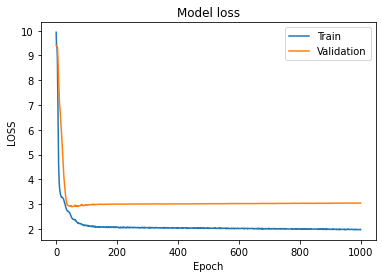

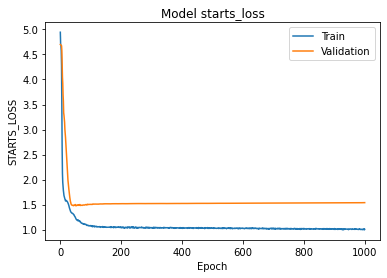

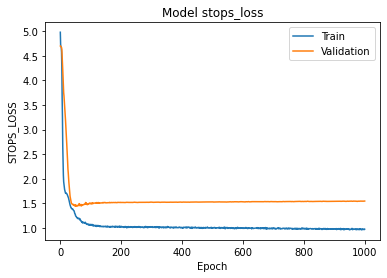

In [49]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss", "accuracy", "starts_accuracy", "stops_accuracy"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [50]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True
)

In [51]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

5201/5201 [==============================] - 1s 244us/sample - loss: 2.8970 - starts_loss: 1.4497 - stops_loss: 1.4370 - starts_accuracy: 0.6055 - stops_accuracy: 0.6135


[2.896954140647561, 1.4496785, 1.4369935, 0.60546046, 0.6135359]

In [52]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test},
                          batch_size=PREDICT_BATCH_SIZE)

In [53]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [54]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(20803, 110) (20803, 110)
(5201, 110) (5201, 110)
(3534, 110) (3534, 110)


In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [56]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [57]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

65.60 	|| train 	|| starts 	|| accuracy_score
72.09 	|| train 	|| stops 	|| accuracy_score
60.55 	|| valid 	|| starts 	|| accuracy_score
72.09 	|| valid 	|| stops 	|| accuracy_score
19.13 	|| train 	|| starts 	|| f1_score
73.16 	|| train 	|| stops 	|| f1_score
5.88 	|| valid 	|| starts 	|| f1_score
73.16 	|| valid 	|| stops 	|| f1_score
35.40 	|| train 	|| starts 	|| precision_score
71.68 	|| train 	|| stops 	|| precision_score
14.90 	|| valid 	|| starts 	|| precision_score
71.68 	|| valid 	|| stops 	|| precision_score
16.21 	|| train 	|| starts 	|| recall_score
75.91 	|| train 	|| stops 	|| recall_score
5.31 	|| valid 	|| starts 	|| recall_score
75.91 	|| valid 	|| stops 	|| recall_score


c:\users\deepak\miniconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	|| train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V10_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V10_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V10_valid_starts.csv
	|| valid 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V10_valid_stops.csv


#### Postprocessing

In [141]:
Y_words_train = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_train)]
Y_words_val = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_val)]

In [65]:
print(sum([s<e for s,e in zip(pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]))

19157
4900
3359


In [134]:
pred_words_train = [t[s:e] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_train], pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]
pred_words_val = [t[s:e] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_val], pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]
pred_words_test = [t[s:e] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_test], pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]

In [135]:
def jaccard(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [144]:
print("Training Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_train, pred_words_train)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_val, pred_words_val)]))

Training Jaccard Score 0.5985801697789666
Validation Jaccard Score 0.5542312685005739


In [145]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

#### Spot Checks

In [152]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_train[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_starts_train[index_to_check].tolist(),
                                                                                               pred_stops_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_val[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                               pred_starts_val[index_to_check].tolist(),
                                                                                               pred_stops_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', pred_words_test[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words_test[index_to_check][num]] for num, (i,j,k) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                               pred_starts_test[index_to_check].tolist(),
                                                                                               pred_stops_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [153]:
for i in range(10,20):
    spot_check(i, mode="train")

================== Sample # 10 ==================
Selected_text:
	 ['says', 'good', '(', 'or', 'should', 'i', 'say', 'bad', '?', ')', 'afternoon', '!']
Predicted_text:
	 ['says', 'good', '(', 'or', 'should', 'i', 'say', 'bad', '?', ')', 'afternoon', '!']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.76', '0.06', 1103, 'says']
	['0.05', '0.12', 448, 'good']
	['0.07', '0.11', 81, '(']
	['0.02', '0.15', 758, 'or']
	['0.01', '0.02', 350, 'should']
	['0.01', '0.08', 7, 'i']
	['0.02', '0.03', 460, 'say']
	['0.01', '0.04', 318, 'bad']
	['0.01', '0.02', 74, '?']
	['0.01', '0.06', 84, ')']
	['0.02', '0.01', 1434, 'afternoon']
	['0.01', '0.06', 22, '!']
	['0.01', '0.16', 47, 'http']
	['0.00', '0.01', 48, ':']
	['0.00', '0.02', 49, '/']
	['0.00', '0.00', 49, '/']
	['0.00', '0.02', 376, 'plurk']
	['0.00', '0.00', 28, '.']
	['0.00', '0.00', 51, 'com']
	['0.00', '0.00', 49, '/']
	['0.00', '0.00', 95, 'p']
	['0.00', '0.01', 49, '/']
	['0.00', '0.02', 1, 'wxpdj']
	['0.00', '0.00', 10, 'xxxSENTI

In [154]:
for i in range(200,210):
    spot_check(i, mode="validation")

================== Sample # 200 ==================
Selected_text:
	 ['bad', 'day', 'the', 'day', 'you', 'realize', 'what', 'mess', 'you`ve', 'put', 'me', 'through', 'will', 'be', 'one', 'of', 'the', 'happiest', 'days', 'of', 'my', 'life', '.', '.', '.']
Predicted_text:
	 ['bad', 'day', 'the', 'day', 'you', 'realize', 'what', 'mess', 'you`ve', 'put', 'me', 'through', 'will', 'be', 'one', 'of', 'the', 'happiest', 'days', 'of', 'my', 'life', '.', '.']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['1.00', '0.00', 318, 'bad']
	['0.00', '0.00', 286, 'day']
	['0.00', '0.00', 42, 'the']
	['0.00', '0.00', 286, 'day']
	['0.00', '0.00', 17, 'you']
	['0.00', '0.00', 972, 'realize']
	['0.00', '0.00', 29, 'what']
	['0.00', '0.00', 345, 'mess']
	['0.00', '0.00', 973, 'you`ve']
	['0.00', '0.00', 39, 'put']
	['0.00', '0.00', 27, 'me']
	['0.00', '0.00', 247, 'through']
	['0.00', '0.00', 15, 'will']
	['0.00', '0.00', 89, 'be']
	['0.00', '0.00', 310, 'one']
	['0.00', '0.00', 34, 'of']
	['0.00', '0.00'

In [155]:
for i in range(10,20):
    spot_check(i, mode="test")

================== Sample # 10 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['have', 'known', 'that', '.']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.12', '0.04', 24, 'my']
	['0.04', '0.04', 977, 'bike']
	['0.05', '0.04', 183, 'was']
	['0.04', '0.05', 39, 'put']
	['0.03', '0.04', 41, 'on']
	['0.04', '0.03', 3270, 'hold']
	['0.03', '0.05', 28, '.']
	['0.03', '0.03', 28, '.']
	['0.04', '0.03', 28, '.']
	['0.07', '0.02', 350, 'should']
	['0.12', '0.06', 4, 'have']
	['0.09', '0.06', 2467, 'known']
	['0.07', '0.06', 82, 'that']
	['0.05', '0.04', 28, '.']
	['0.06', '0.13', 28, '.']
	['0.03', '0.08', 28, '.']
	['0.03', '0.04', 28, '.']
	['0.02', '0.01', 1286, 'argh']
	['0.02', '0.02', 1291, 'total']
	['0.01', '0.08', 5242, 'bummer']
	['0.01', '0.01', 10, 'xxxSENTIMENT']
	['0.00', '0.01', 23, 'negative']
	['0.00', '0.01', 12, 'xxxEND']
================== Sample # 11 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['i', 'checked', '.', 'we', 